## Evaluación del riesgo crediticio 

El riesgo de incumplimiento crediticio es la posibilidad de que las empresas/individuos no puedan realizar los pagos requeridos por sus obligaciones de deuda, lo que puede generar una posibilidad de pérdida para un prestamista.

* Feature Name	|        Description
* person_age	|       Edad
* person_income	| Ingresos anuales (USD)
* person_home_ownership	| Propiedad de la vivienda
* person_emp_length	| Duración del empleo (en años)
* loan_intent |	Intención de préstamo
* loan_grade  |	Grado de préstamo
* loan_amnt |	Monto del préstamo
* loan_int_rate |	Tasa de interés
* loan_status |	Estado del préstamo (0 non default, 1 default (incumplimiento))
* loan_percent_income |	Porcentaje de ingresos
* cb_person_default_on_file |	Incumplimiento histórico
* cb_preson_cred_hist_length |	Longitud del historial crediticio

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import plotly.graph_objects as go
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
import warnings, gc
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from feature_engine.outliers import Winsorizer
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, DropDuplicateFeatures
from catboost import CatBoostClassifier
from xgboost import XGBRFClassifier, XGBClassifier
from lightgbm import LGBMClassifier

from scipy.stats import probplot
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter
from yellowbrick.classifier import ClassPredictionError

In [137]:
df_credit_risk = pd.read_csv("credit_risk_dataset.csv")
df_credit_risk.head(10)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
6,26,77100,RENT,8.0,EDUCATION,B,35000,12.42,1,0.45,N,3
7,24,78956,RENT,5.0,MEDICAL,B,35000,11.11,1,0.44,N,4
8,24,83000,RENT,8.0,PERSONAL,A,35000,8.90,1,0.42,N,2
9,21,10000,OWN,6.0,VENTURE,D,1600,14.74,1,0.16,N,3


In [138]:
df_credit_risk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [139]:
df_credit_risk.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [140]:
df_credit_risk.shape

(32581, 12)

In [141]:
df = df_credit_risk.copy()

In [142]:
df.to_csv('C:\FP-UNA\ML engineer\Projects\Project 4/riesgo_crediticio.csv', index=False)

In [143]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [144]:
diccionario = {'person_age':'persona_edad',
                        'person_income': 'persona_ingreso',
                        'person_home_ownership': 'persona_propiedad_de_vivienda',
                        'person_emp_length': 'persona_empleo_duracion',
                        'loan_intent': 'intencion_prestamo',
                        'loan_grade': 'grado_prestamo',
                        'loan_amnt': 'monto_prestamo',
                        'loan_int_rate': 'tasa_de_interes',
                        'loan_status': 'estado_prestamo',
                        'loan_percent_income': 'Porcent_ingresos',
                        'cb_person_default_on_file': 'cb_persona_incumplimiento_historico',
                        'cb_person_cred_hist_length': 'cb_persona_historial_crediticio_length'}

## Data preprocessing
* Cambiar el idioma 
* Eliminar filas de valores NaN de datos.

#### ENG --- > ESP
* RENT ---> renta
* OWN ---> propia
* MORTGAGE ----> hipoteca
* OTHER ----> otro

* personal ----> personal
* education ----> educacion
* medical ----> medica
* HOMEIMPROVEMENT ---> MEJORAS PARA EL HOGAR
* VENTURE ----> Empresa
* DEBTCONSOLIDATION----> CONSOLIDACIÓN DE LA DEUDA


In [145]:
df = df.rename(columns={'person_age':'persona_edad',
                        'person_income': 'persona_ingreso',
                        'person_home_ownership': 'persona_propiedad_de_vivienda',
                        'person_emp_length': 'persona_empleo_duracion',
                        'loan_intent': 'intencion_prestamo',
                        'loan_grade': 'grado_prestamo',
                        'loan_amnt': 'monto_prestamo',
                        'loan_int_rate': 'tasa_de_interes',
                        'loan_status': 'estado_prestamo',
                        'loan_percent_income': 'Porcent_ingresos',
                        'cb_person_default_on_file': 'cb_persona_incumplimiento_historico',
                        'cb_person_cred_hist_length': 'cb_persona_historial_crediticio_length'})

In [146]:
df['persona_propiedad_de_vivienda'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object)

In [147]:
df.isna().sum()

persona_edad                                 0
persona_ingreso                              0
persona_propiedad_de_vivienda                0
persona_empleo_duracion                    895
intencion_prestamo                           0
grado_prestamo                               0
monto_prestamo                               0
tasa_de_interes                           3116
estado_prestamo                              0
Porcent_ingresos                             0
cb_persona_incumplimiento_historico          0
cb_persona_historial_crediticio_length       0
dtype: int64

In [148]:
df = df.drop_duplicates()

In [149]:
df = df.dropna()
df.isnull().sum()

persona_edad                              0
persona_ingreso                           0
persona_propiedad_de_vivienda             0
persona_empleo_duracion                   0
intencion_prestamo                        0
grado_prestamo                            0
monto_prestamo                            0
tasa_de_interes                           0
estado_prestamo                           0
Porcent_ingresos                          0
cb_persona_incumplimiento_historico       0
cb_persona_historial_crediticio_length    0
dtype: int64

In [150]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    grab_col_names for given dataframe

    :param dataframe:
    :param cat_th:
    :param car_th:
    :return:
    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, cat_but_car, num_cols

cat_cols, cat_but_car, num_cols = grab_col_names(df)

Observations: 28501
Variables: 12
cat_cols: 5
num_cols: 7
cat_but_car: 0
num_but_cat: 1


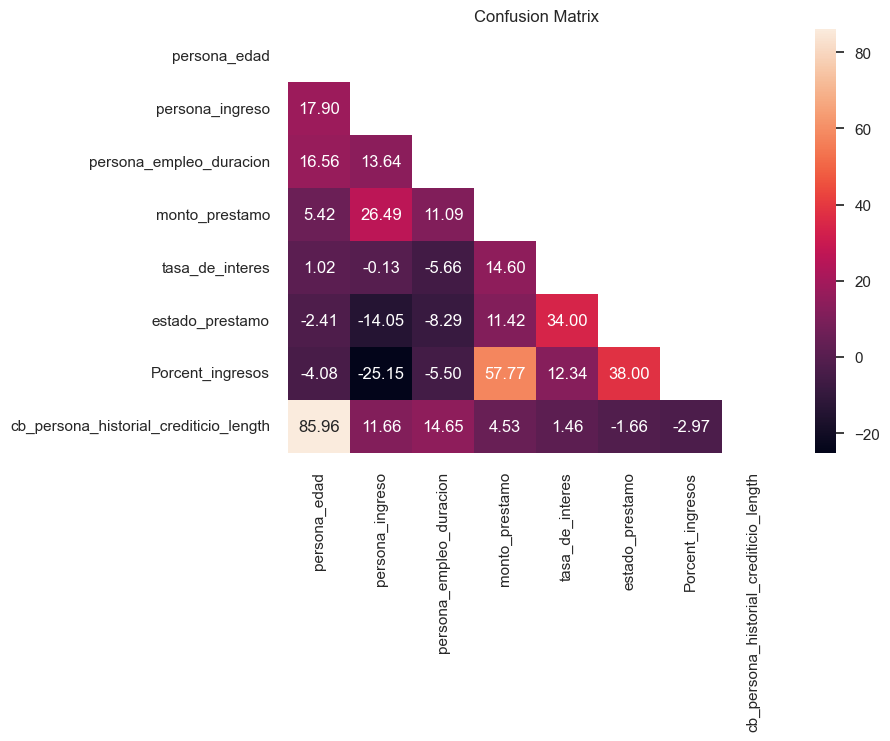

['cb_persona_historial_crediticio_length']

In [151]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    
    '''sirve para identificar columnas altamente correlacionadas en un DataFrame'''
    
    # Seleccionar solo las columnas numéricas del DataFrame
    numeric_dataframe = dataframe.select_dtypes(include=['number'])
    # Calcular la matriz de correlación
    corr = numeric_dataframe.corr()
    cor_matrix = corr.abs()
    # Seleccionar la parte superior del triángulo de la matriz de correlación
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    # Identificar las columnas que tienen una correlación superior al umbral especificado
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    
    # Si se especifica, graficar la matriz de correlación
    if plot:
        mask = np.zeros_like(corr)
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(corr * 100, annot= True, fmt='.2f', mask=mask)
        plt.title('Confusion Matrix')
        plt.show()
    
    return drop_list

# Ejemplo
high_correlated_cols(df, plot=True)

In [152]:
# Cambiar idioma
df['persona_propiedad_de_vivienda'] = df['persona_propiedad_de_vivienda'].apply(lambda x: 'renta' if x =='RENT' else 'propia' if x=='OWN' else 'hipoteca' if x=='MORTGAGE' else 'otro')
df['intencion_prestamo'] = df['intencion_prestamo'].apply(lambda x: 'personal' if x=='PERSONAL' else 'educacion' if x=='EDUCATION' else 'medica' if x=='MEDICAL' else 'mejoras para el hogar' if x=='HOMEIMPROVEMENT' else 'empresa' if x=='VENTURE' else 'consolidacion de la deuda')


In [154]:
df.head()

,persona_edad,persona_ingreso,persona_propiedad_de_vivienda,persona_empleo_duracion,intencion_prestamo,grado_prestamo,monto_prestamo,tasa_de_interes,estado_prestamo,Porcent_ingresos,cb_persona_incumplimiento_historico,cb_persona_historial_crediticio_length
0,22,59000,renta,123.0,personal,D,35000,16.02,1,0.59,Y,3
1,21,9600,propia,5.0,educacion,B,1000,11.14,0,0.10,N,2
2,25,9600,hipoteca,1.0,medica,C,5500,12.87,1,0.57,N,3
3,23,65500,renta,4.0,medica,C,35000,15.23,1,0.53,N,2
4,24,54400,renta,8.0,medica,C,35000,14.27,1,0.55,Y,4


In [156]:
# Configuracion de diseño del grafico
temp = dict(layout=go.Layout(font=dict(family='Franklin Gothic', size=12),
                             height=500, width=1000))
# Cálculo de la distribucion del objetivo
target= df.estado_prestamo.value_counts(normalize=True)
target.rename(index={1:'Default (Incumplimiento)', 0:'non default'}, inplace=True)
pal, color =['#016CC9','#DEB078'], ['#8DBAE2','#EDD3B3'] #Definicion de colores

# Creación del gráfico circular:
fig= go.Figure()
fig.add_trace(go.Pie(labels=target.index, values=target*100, hole=.45,
                     showlegend=True, sort=False,
                     marker=dict(colors=color, line=dict(color=pal, width=2.5)),
                     hovertemplate="%{label} Accounts: %{value:.2f}%<extra></extra>"))

# Actualización de la configuración del diseño
fig.update_layout(template=temp, title = 'Distribución del Objetivo',
                  legend=dict(traceorder='reversed', y=1.05, x=0),
                  uniformtext_minsize= 15, uniformtext_mode='hide', width=700)

fig.show()

## Identificar y verificar la presencia de valores atípicos (outliers)

In [157]:
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    
    '''Esta función calcula los límites inferior y superior para identificar los valores atípicos en una columna específica del DataFrame.
    Se utiliza un enfoque basado en percentiles, donde low_quantile y up_quantile determinan los percentiles inferior y superior, respectivamente.
    Por defecto, se utilizan los percentiles 10 y 90.'''
    
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

# Control de valores atípicos 
def check_outlier(dataframe, col_name):
    
    '''Esta función utiliza los límites calculados por outlier_thresholds 
    para verificar si hay algún valor atípico en la columna especificada (col_name) del DataFrame.'''
    
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

# Bucle para verificar outliers en columnas numéricas:
'''Este bucle itera sobre las columnas numéricas (num_cols) del DataFrame df y verifica la presencia de valores atípicos
utilizando la función check_outlier. La condición col != "loan_status" asegura que la columna de estado del préstamo ("estado_prestamo") no se incluya en la verificación de valores atípicos.'''    
for col in num_cols:
    if col != "estado_prestamo":
        print(col, check_outlier(df, col))
        

persona_edad True
persona_ingreso True
persona_empleo_duracion True
monto_prestamo False
tasa_de_interes False
Porcent_ingresos True
cb_persona_historial_crediticio_length True


A continuación, el siguiente código proporciona una forma de reemplazar los valores atípicos en columnas numéricas de un DataFrame con los límites calculados mediante el rango intercuartílico (IQR). Esto puede ser útil para mitigar el impacto de los valores atípicos en el análisis y los modelos.

In [158]:
def replace_with_thresholds(dataframe, variable):
    
    '''Esta función utiliza los límites inferior y superior calculados por la función outlier_thresholds 
    para reemplazar los valores atípicos en la columna especificada (variable) del DataFrame con los límites correspondientes.'''
    
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

#Bucle para reemplazar outliers en columnas numéricas:
'''Este bucle itera sobre las columnas numéricas (num_cols) del DataFrame df y utiliza la función replace_with_thresholds 
para reemplazar los valores atípicos en cada columna, excepto en la columna de estado del préstamo ("estado_prestamo").'''
for col in num_cols:
    if col != "estado_prestamo":
        replace_with_thresholds(df,col)

Distribución de la edad en función del estado del préstamo (bueno, malo o en general)

In [159]:
import plotly.tools as tls 
import plotly.offline as py 

# Creación de listas de datos:
df_good = df.loc[df["estado_prestamo"]==1]['persona_edad'].values.tolist()
df_bad = df.loc[df["estado_prestamo"]==0]['persona_edad'].values.tolist()
df_age = df['persona_edad'].values.tolist()

# primer plot
trace0 = go.Histogram(
    x=df_good,
    histnorm = 'probability',
    name= "estado de prestamo = 1")

#segundo plot
trace1 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name = "estado de prestamo = 0")

#tercer plot
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name= "Edad general")

fig = tls.make_subplots(rows=2, cols=2, specs=[[{},{}], [{'colspan': 2}, None]],
                        subplot_titles=('Bueno', 'Malo', 'Distribución General'))

#settings
fig.append_trace(trace0, 1,1)
fig.append_trace(trace1, 1,2)
fig.append_trace(trace2, 2,1)

fig['layout'].update(showlegend=True, title='Distribución por Edad', bargap=0.05)
py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

In [160]:
trace0 = go.Bar(
    x = df[df["estado_prestamo"]== 1]["persona_propiedad_de_vivienda"].value_counts().index.values,
    y = df[df["estado_prestamo"]== 1]["persona_propiedad_de_vivienda"].value_counts().values,
    name='estado de prestamo = 1',
    
)

#Segundo plot
trace1 = go.Bar(
    x = df[df["estado_prestamo"]== 0]["persona_propiedad_de_vivienda"].value_counts().index.values,
    y = df[df["estado_prestamo"]== 0]["persona_propiedad_de_vivienda"].value_counts().values,
    name="estado de prestamo = 0"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Distribución de Vivienda'
)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Distribución de Vivienda')


In [161]:
trace0 = go.Bar(
    x = df[df["estado_prestamo"]== 1]["grado_prestamo"].value_counts().index.values,
    y = df[df["estado_prestamo"]== 1]["grado_prestamo"].value_counts().values,
    name='estado de prestamo = 1'
)

#Segundo plot
trace1 = go.Bar(
    x = df[df["estado_prestamo"]== 0]["grado_prestamo"].value_counts().index.values,
    y = df[df["estado_prestamo"]== 0]["grado_prestamo"].value_counts().values,
    name="estado de prestamo = 0"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Clasificación del prestamo'
)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Clasificación del prestamo')


In [162]:
trace0 = go.Bar(
    x = df[df["estado_prestamo"]== 1]["intencion_prestamo"].value_counts().index.values,
    y = df[df["estado_prestamo"]== 1]["intencion_prestamo"].value_counts().values,
    name='estado de prestamo = 1'
)

#Second plot
trace1 = go.Bar(
    x = df[df["estado_prestamo"]== 0]["intencion_prestamo"].value_counts().index.values,
    y = df[df["estado_prestamo"]== 0]["intencion_prestamo"].value_counts().values,
    name="estado de prestamo = 0"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Intención de prestamo'
)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Intención de prestamo')

<Figure size 800x550 with 0 Axes>

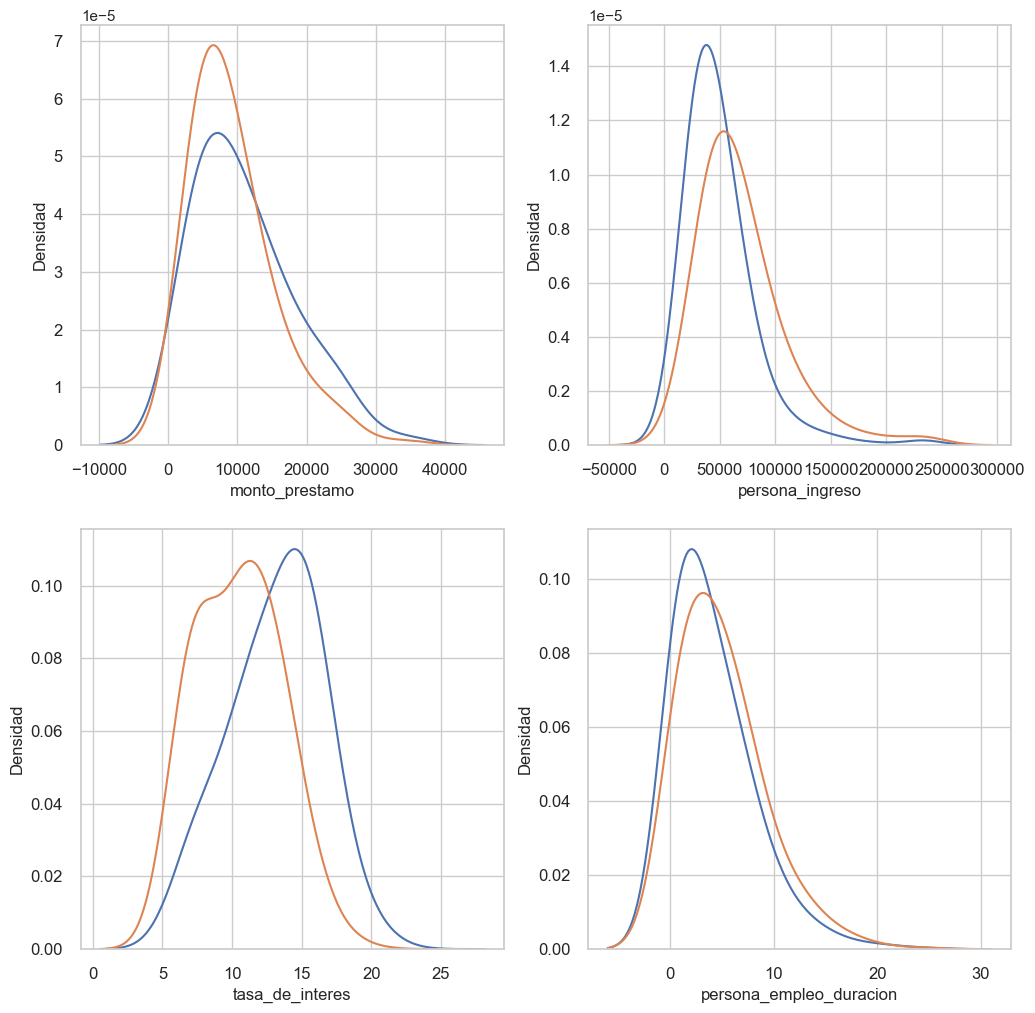

In [163]:
def plot_distribution_comp(var, nrow=2):
    
    '''Este código es para trazar gráficos de densidad de las distribuciones de varias variables numéricas en función del estado del préstamo'''
    i=0
    #seperacion de datos segun el estado del prestamo
    t1 = df.loc[df['estado_prestamo'] != 0]
    t0 = df.loc[df['estado_prestamo'] == 0]
    
    #configuracion del seaborn y matplotlib
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow, 2, figsize=(12, 6*nrow))
    
    #Buble para trazar graficos de densidad para cada variable
    for feature in var:
        i += 1
        plt.subplot(nrow, 2, i)
        sns.kdeplot(t1[feature], bw_method=0.5, label='TARGET = 1')
        sns.kdeplot(t0[feature], bw_method=0.5, label='TARGET = 0')
        plt.ylabel('Densidad', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

var = ['monto_prestamo','persona_ingreso','tasa_de_interes','persona_empleo_duracion']
plot_distribution_comp(var, nrow=2)
    

In [164]:
'''ue clasifica las observaciones en grupos de ingresos según los intervalos y las etiquetas especificadas. 
Este tipo de agrupación es útil para realizar análisis basados en categorías de ingresos en lugar de valores continuos.'''
df['grupo_de_ingresos'] = pd.cut(df['persona_ingreso'],
                              bins=[0, 25000, 50000, 75000, 100000, float('inf')],
                              labels=['bajo', 'bajo-medio', 'medio', 'alto-medio', 'alto'])

la codificación one-hot de las columnas categóricas en el DataFrame dfx y actualiza el DataFrame con estas nuevas columnas dummy. La codificación one-hot es útil para convertir variables categóricas en un formato que los modelos de machine learning pueden entender mejor.

In [165]:
dfx=df.copy()
cat_cols, cat_but_car, num_cols = grab_col_names(dfx) # Actualizamos el último estado numérico y categórico de las variables.
cat_cols.remove("estado_prestamo")


def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first,dtype=int)
    return dataframe

dfx = one_hot_encoder(dfx, cat_cols, drop_first=True)

Observations: 28501
Variables: 13
cat_cols: 6
num_cols: 7
cat_but_car: 0
num_but_cat: 2


In [166]:
X = dfx.drop(['estado_prestamo',"persona_edad","persona_ingreso"], axis=1)
y = dfx['estado_prestamo']

se aplica una serie de transformaciones en una pipeline al conjunto de datos X con el objetivo de eliminar características constantes, correlacionadas y duplicadas. Cada paso de la pipeline está asociado con una función o clase que realiza la tarea de eliminación de características específica.

In [167]:
pipeline = Pipeline(steps=[
    ('constant', DropConstantFeatures()),
    ('correlated', DropCorrelatedFeatures()),
    ('duplicated', DropDuplicateFeatures())
])

X = pipeline.fit_transform(X)
X.shape

(28501, 24)

este código utiliza BorderlineSMOTE (Synthetic Minority Over-sampling Technique) para abordar el desbalance de clases en el conjunto de datos realizando sobremuestreo de la clase minoritaria. Después de aplicar BorderlineSMOTE, imprime las dimensiones finales de las clases de la variable objetivo para verificar el efecto del sobremuestreo.

In [168]:
smote = BorderlineSMOTE()
X, y = smote.fit_resample(X, y)
print("Dimensiones finales de las clases de etiquetas de destino:", Counter(y))

Dimensiones finales de las clases de etiquetas de destino: Counter({1: 22313, 0: 22313})


In [169]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
# Scaling variables
scaler = StandardScaler()

# Scaler = RobustScaler()
scaled_train_X = scaler.fit_transform(X_train)
scaled_test_X = scaler.transform(X_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4463
           1       0.98      0.92      0.95      4463

    accuracy                           0.95      8926
   macro avg       0.95      0.95      0.95      8926
weighted avg       0.95      0.95      0.95      8926

--------------------------------------------------


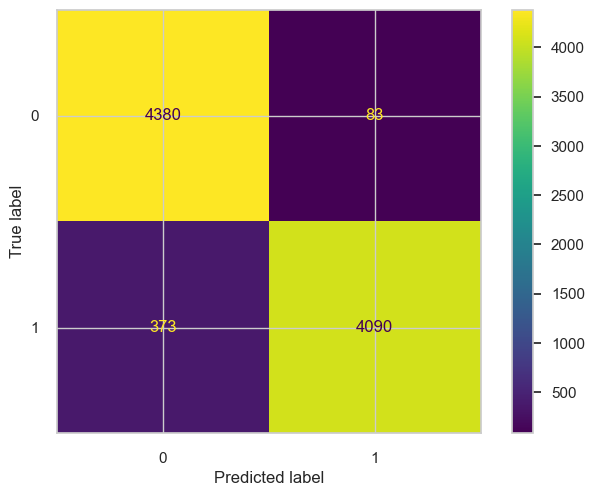

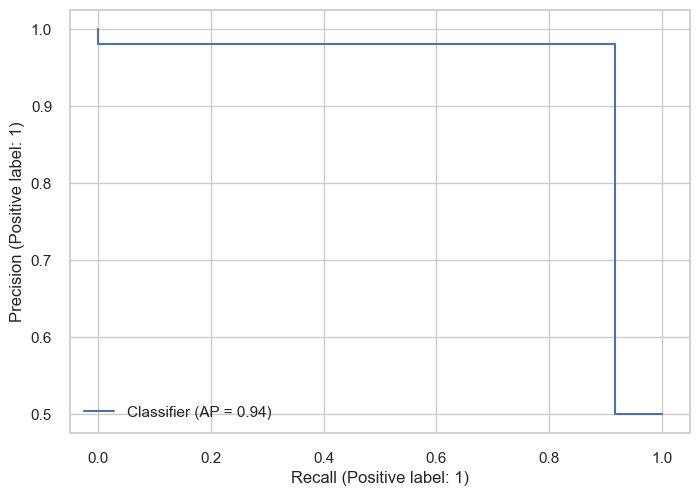

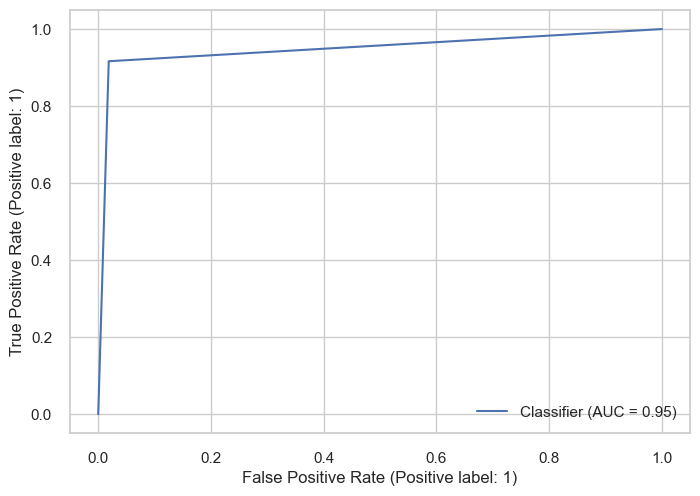

In [170]:
import re
models = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

def train_and_evaluate_model(model):
    
    model.fit(scaled_train_X, y_train)
    y_pred = model.predict(scaled_test_X)
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print('-'*50)
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    PrecisionRecallDisplay.from_predictions(y_test, y_pred)
    RocCurveDisplay.from_predictions(y_test, y_pred)
    
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    roc_auc = roc_auc_score(y_test, y_pred, average='macro')

    if re.search('catboost', str(model)) == None:
        visualizer = ClassPredictionError(model)
        visualizer.score(scaled_test_X, y_test)
        visualizer.show()
        del visualizer
    
    accuracy_scores.append(acc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    models.append(model)
    del acc, precision, recall,f1,roc_auc
    gc.collect()

train_and_evaluate_model(CatBoostClassifier(silent=True))
    

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4463
           1       0.98      0.91      0.94      4463

    accuracy                           0.95      8926
   macro avg       0.95      0.95      0.95      8926
weighted avg       0.95      0.95      0.95      8926

--------------------------------------------------


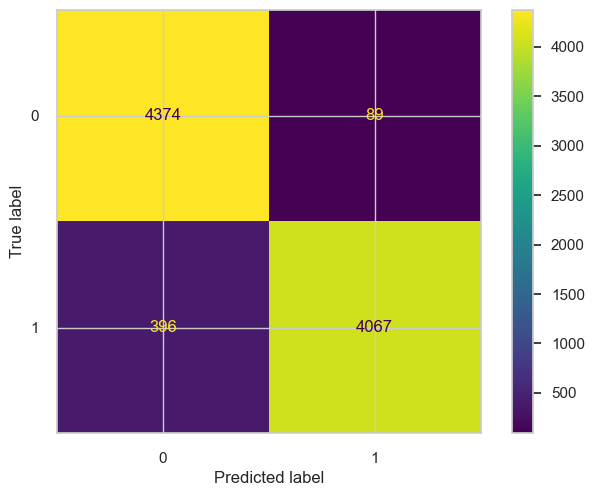

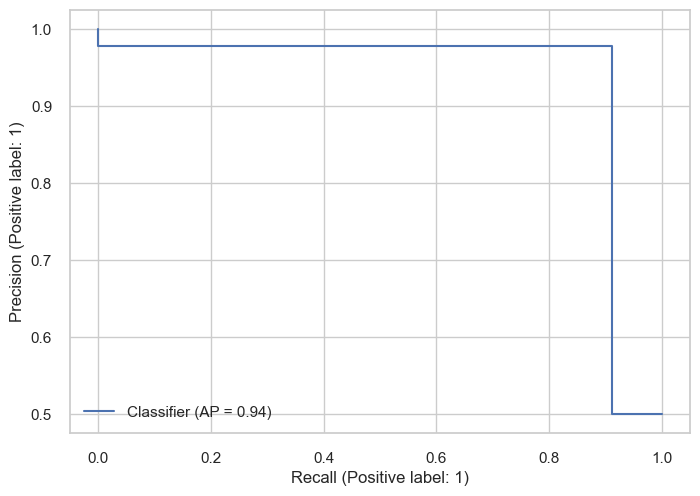

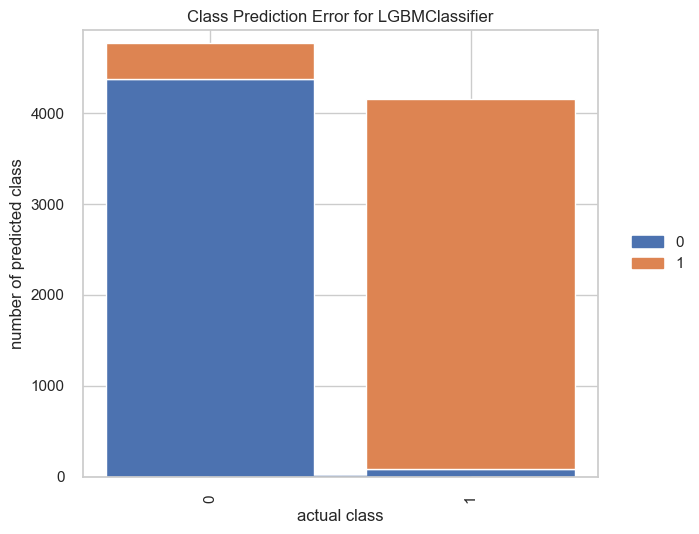

In [171]:
train_and_evaluate_model(LGBMClassifier(verbose= -1))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      4463
           1       0.96      0.92      0.94      4463

    accuracy                           0.94      8926
   macro avg       0.94      0.94      0.94      8926
weighted avg       0.94      0.94      0.94      8926

--------------------------------------------------


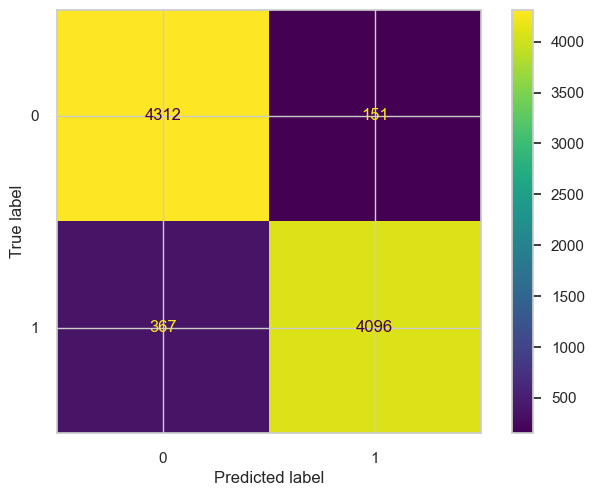

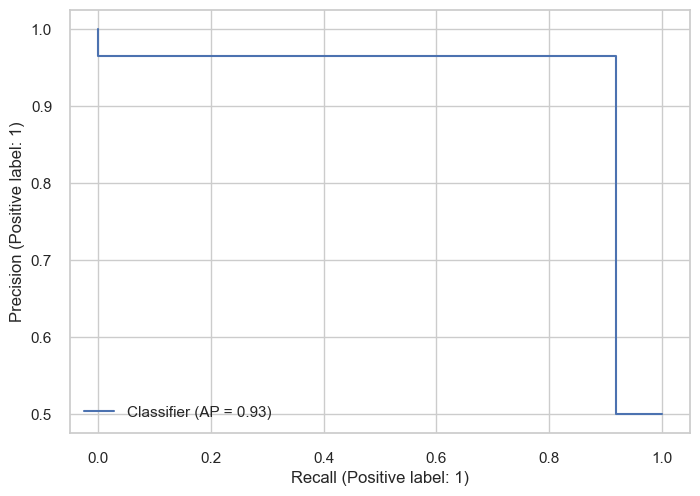

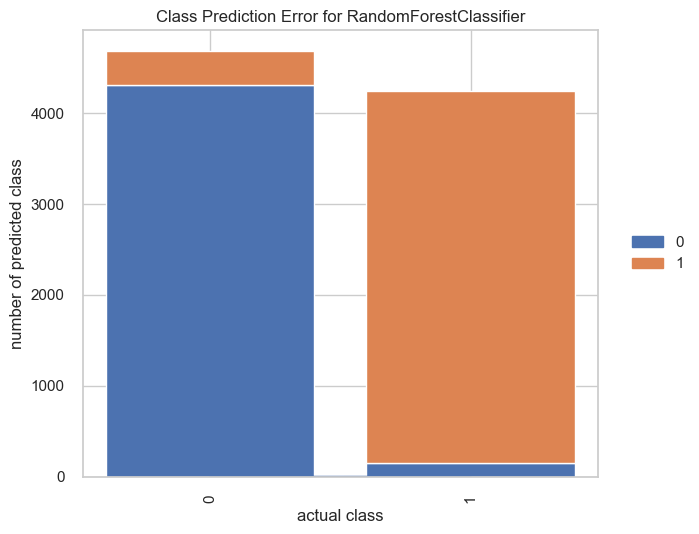

In [172]:
train_and_evaluate_model(RandomForestClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4463
           1       0.98      0.92      0.95      4463

    accuracy                           0.95      8926
   macro avg       0.95      0.95      0.95      8926
weighted avg       0.95      0.95      0.95      8926

--------------------------------------------------


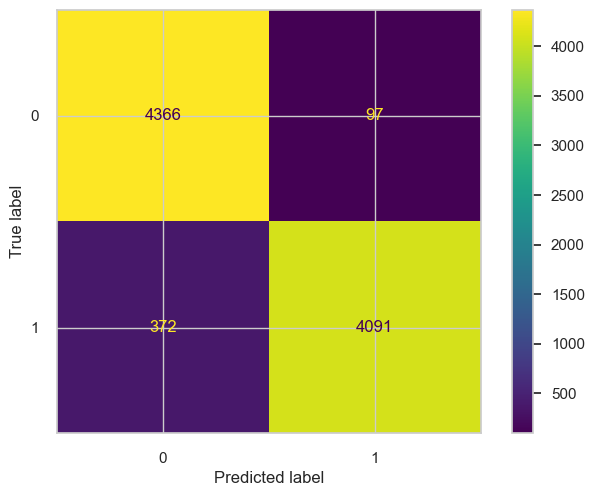

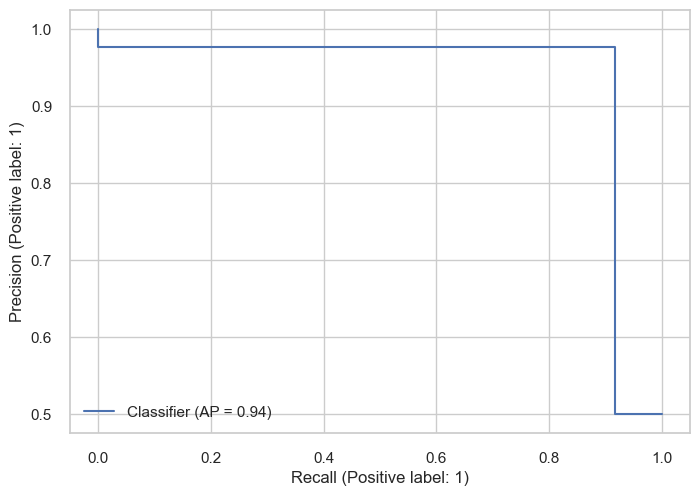

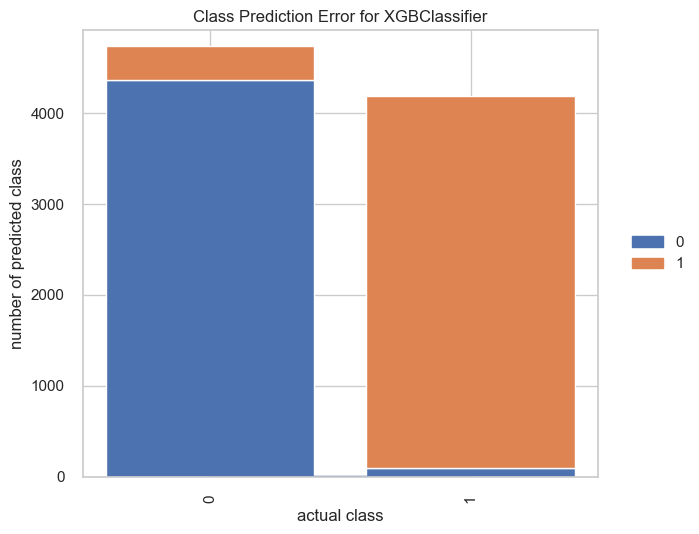

In [173]:
train_and_evaluate_model(XGBClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4463
           1       0.92      0.84      0.88      4463

    accuracy                           0.88      8926
   macro avg       0.89      0.88      0.88      8926
weighted avg       0.89      0.88      0.88      8926

--------------------------------------------------


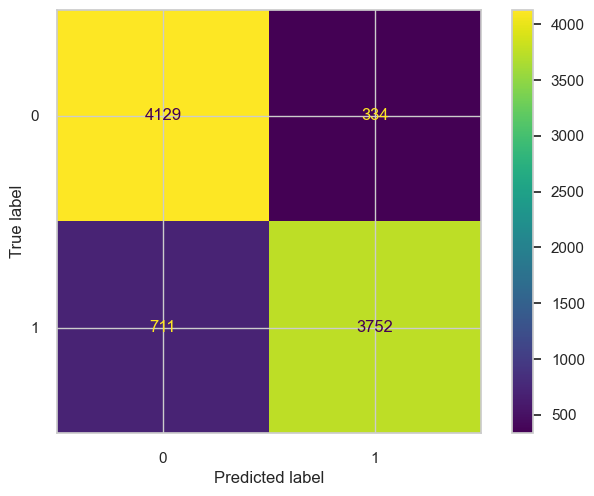

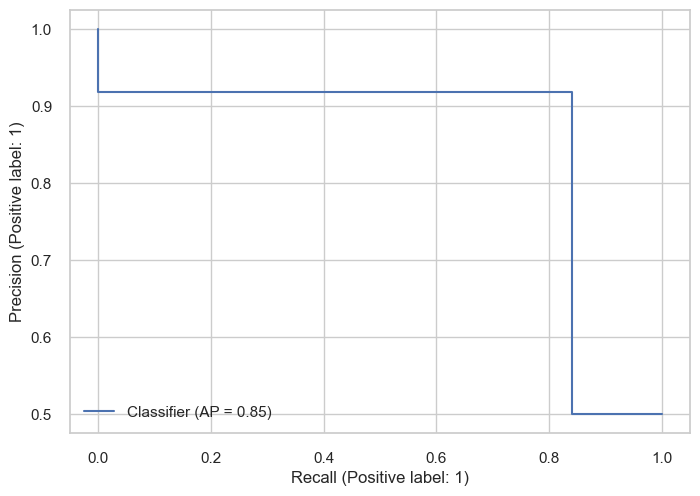

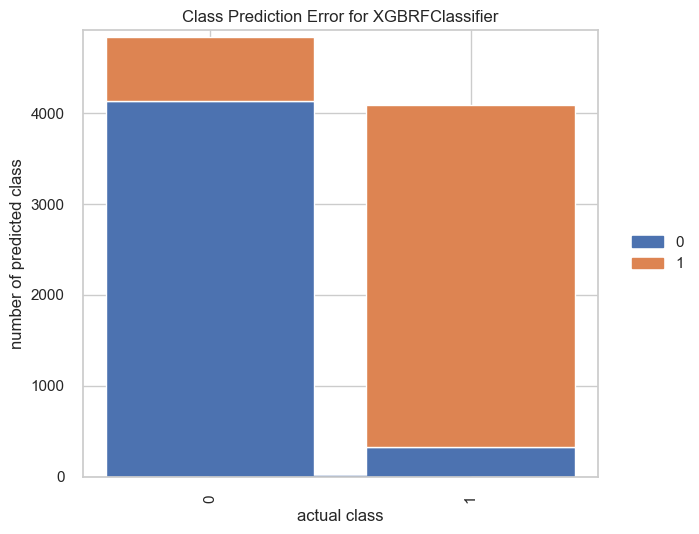

In [174]:
train_and_evaluate_model(XGBRFClassifier())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.6s finished


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      4463
           1       0.98      0.92      0.95      4463

    accuracy                           0.95      8926
   macro avg       0.95      0.95      0.95      8926
weighted avg       0.95      0.95      0.95      8926

--------------------------------------------------


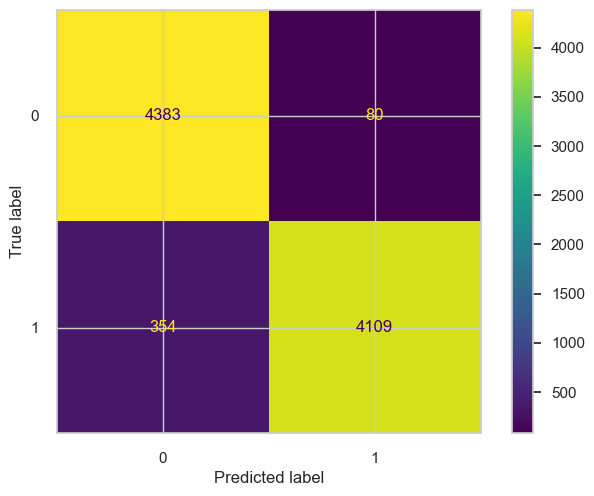

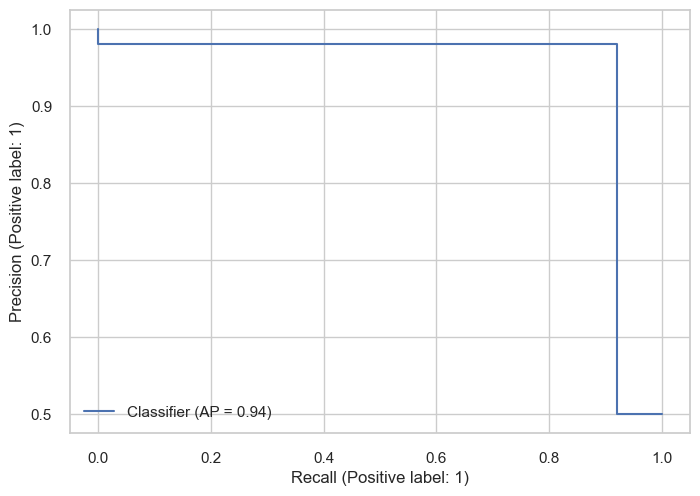

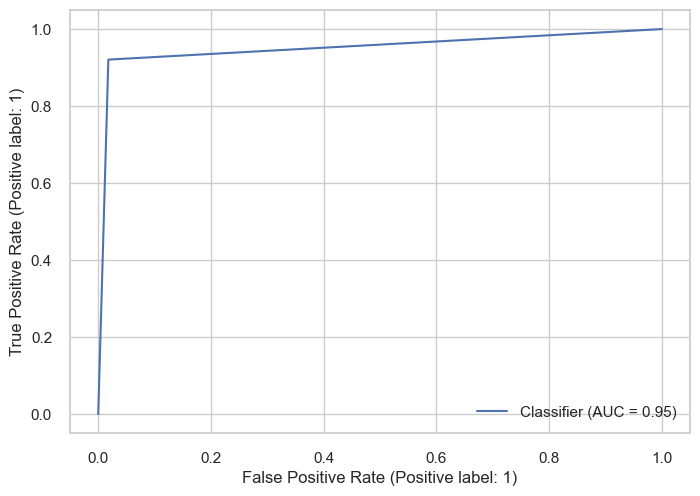

In [175]:
from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier

train_and_evaluate_model(StackingClassifier(estimators=[
    ('ET', ExtraTreesClassifier()),
    ('XGB', XGBClassifier()),
    ('CAT', CatBoostClassifier(silent=True))
], final_estimator= RandomForestClassifier(), verbose=2))

In [176]:
models_perfs = pd.DataFrame({'Model': models,
                             'Accuracy': accuracy_scores,
                             'Precision': precision_scores,
                             'Recall': recall_scores,
                             'F1': f1_scores,
                             'ROC-AUC': roc_auc_scores}).sort_values('Accuracy', ascending=False).reset_index(drop=True)

models_perfs

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,"StackingClassifier(estimators=[('ET', ExtraTre...",0.951378,0.953086,0.951378,0.951332,0.951378
1,<catboost.core.CatBoostClassifier object at 0x...,0.948913,0.950817,0.948913,0.948859,0.948913
2,"XGBClassifier(base_score=None, booster=None, c...",0.947457,0.949162,0.947457,0.947407,0.947457
3,LGBMClassifier(verbose=-1),0.945664,0.947783,0.945664,0.945600,0.945664
4,"(DecisionTreeClassifier(max_features='sqrt', r...",0.941967,0.943005,0.941967,0.941933,0.941967
5,"XGBRFClassifier(base_score=None, booster=None,...",0.882926,0.885678,0.882926,0.882717,0.882926


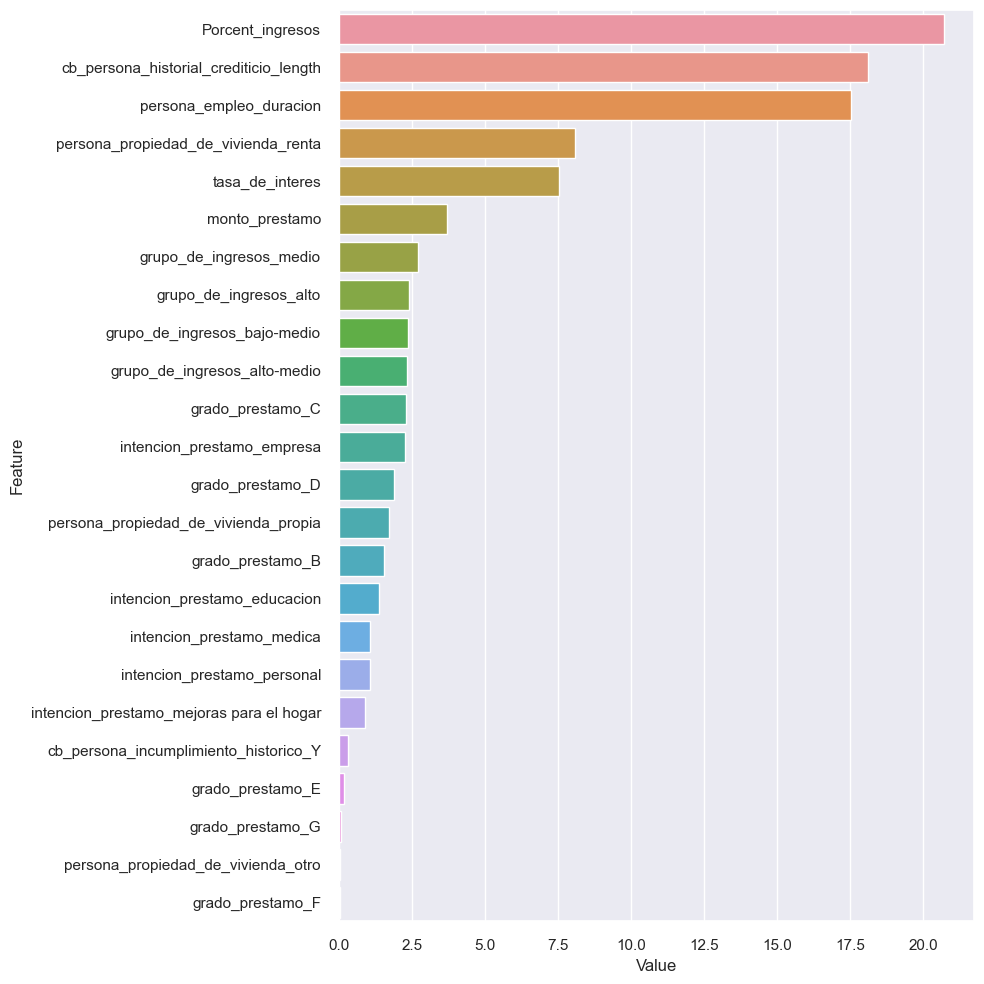

In [177]:
def plot_importance(model, features, num=len(X), save=False):
    
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10,10))
    sns.set(font_scale=1)
    sns.barplot(x='Value', y='Feature', data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
        
model = CatBoostClassifier(silent=True)
model.fit(X, y)

plot_importance(model, X)

In [180]:
#Grabamos el modelo en el directorio
import pickle 
pkl_filename = "Predicción_Riesgo_Crediticio.pkl"
with open(pkl_filename, "wb") as file:
    pickle.dump(model, file)

In [181]:
# Cargar modelo
pkl_filename = "Predicción_Riesgo_Crediticio.pkl"
with open(pkl_filename, "rb") as file:
    model = pickle.load(file)

In [182]:
#Encontramos el accuracy promedio usando datos del test
score = model.score(X_test, y_test)
print(score)

0.9604526103517813


In [188]:
#probando  con una muestra nueva
x_in = np.asarray([28,	35000,	15.0,	21000,	13.02,	0,	0.38,	2.0,0,	0,0,0,1,0,1,1,0,	0,	1,	0,	0,	0,	1,	0,	1,	0,	0]).reshape(1,-1)
predicts = model.predict(x_in)
predicts[0]

1